## AI Forensics Report: (S)elected Moderation
### Measuring the Moderation of Election-Related Content Across Chatbots, Languages and Electoral Contexts

July 31st, 2024

### Imports and functions

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

language_names = {
    "en": "English",
    "cs": "Czech",
    "da": "Danish",
    "de": "German",
    "el": "Greek",
    "nl": "Dutch",
    "it": "Italian",
    "pl": "Polish",
    "sk": "Slovak",
    "ro": "Romanian",
    "es": "Spanish",
    "fr": "French",
    "sv": "Swedish",
}

# Arguments for placeholders in the counterfactual experiment
placeholder_arguments = {
    "varEU1": "EU",
    "varEU2": "European",
    "varEU3": "European Parliamentary",
    "varEU4": "Euro",
    "varEU5": "European Union",
    "varUS1": "US",
    "varUS2": "American",
    "varUS3": "US Presidential",
    "varUS4": "American Presidential",
    "varUS5": "United States",
}


def load_and_clean_data(file_path):
    """
    Load and clean the dataset, dropping rows with a missing value in the 'answer' column.

    Args:
    file_path (str): The path to the CSV file.

    Returns:
    pd.DataFrame: Cleaned DataFrame with missing values handled.
    """
    df = pd.read_csv(file_path)
    df = df.dropna(subset=["answer"])
    return df


def extract_bing_related_answers(df):
    """
    Extract all unique answers across all languages that contain the word 'Bing'.

    Args:
    df (pd.DataFrame): The cleaned dataset.

    Returns:
    dict: A dictionary with language codes as keys and sets of unique Bing-related answers as values.
    """
    bing_related_answers = df[df["answer"].str.contains("Bing", case=False, na=False)]
    return (
        bing_related_answers.groupby("language")["answer"]
        .apply(lambda x: set(x))
        .to_dict()
    )


def extract_trailing_string(user_action_set):
    """
    Extracts the trailing string after the last dash, to identify the argument used to instantiate the prompt template.
    """
    if user_action_set:
        parts = user_action_set.split("-")
        if len(parts) > 1:
            return parts[-1]
    return None


def extract_trailing_digits(template_slug):
    """Extracts the trailing digits from a template_slug string."""

    match = re.findall(r"\d+$", template_slug)
    if match:
        return int(match[0])
    return 0


def print_bing_related_answers(bing_related_answers):
    """
    Print the unique Bing Search-related answers for each language.

    Args:
    bing_related_answers (dict): A dictionary of unique Bing-related answers by language.
    """
    print("Identified unique Bing Search-related sentences by language:\n")
    for language, sentences in bing_related_answers.items():
        print(f"Language: {language}")
        for sentence in sentences:
            print(f" - {sentence}")
        print(
            f"Total unique sentences: {len(sentences)}\n"
        )  # Print the total count for each language
        print("\n")  # Add a blank line between languages


def classify_moderated_answers(df, bing_related_answers):
    """
    Classify answers as 'Moderated' if they contain any Bing-related sentences.

    Args:
    df (pd.DataFrame): The cleaned dataset.
    bing_related_answers (dict): A dictionary of Bing-related answers by language.

    Returns:
    pd.DataFrame: The dataset with a new 'Moderated' column.
    """
    df["Moderated"] = df.apply(
        lambda row: any(
            sentence in row["answer"]
            for sentence in bing_related_answers.get(row["language"], [])
        ),
        axis=1,
    )
    return df


def calculate_moderation_proportions(df):
    """
    Calculate the number of 'Moderated' responses for each language and the total number of responses.

    Args:
    df (pd.DataFrame): The dataset with 'Moderated' classification.

    Returns:
    pd.DataFrame: A DataFrame with language codes, count of moderated responses, and total responses.
    """
    moderated_counts = (
        df.groupby("language")["Moderated"].sum().reset_index(name="moderated_count")
    )
    total_answers = (
        df.groupby("language")["answer"].count().reset_index(name="total_answers")
    )
    moderated_counts = moderated_counts.merge(total_answers, on="language")
    return moderated_counts


def generate_donut_charts(moderated_counts):
    """
    Generate donut charts showing the proportion of 'Moderated' vs. 'Not Moderated' answers for each language,
    alongside the run totals for each category.

    Args:
    moderated_counts (pd.DataFrame): DataFrame with moderation counts and total answers by language.
    """
    for language in moderated_counts["language"]:
        data = moderated_counts[moderated_counts["language"] == language]
        labels = ["Moderated", "Not Moderated"]
        colors = ["orange", "lightgrey"]
        sizes = [
            data["moderated_count"].values[0],
            data["total_answers"].values[0] - data["moderated_count"].values[0],
        ]

        # Get the full language name
        full_language_name = language_names.get(language, language)

        # Print the run totals for each language
        print(f"{full_language_name}:")
        print(
            f"Moderated: {sizes[0]}, Not Moderated: {sizes[1]}, Total: {sum(sizes)}\n"
        )

        # Creating the donut chart
        plt.figure(figsize=(2, 2))
        plt.pie(
            sizes,
            labels=labels,
            colors=colors,
            autopct="%1.1f%%",
            startangle=140,
            wedgeprops=dict(width=0.3),
        )
        plt.title(full_language_name)  # Only the full language name as the title
        plt.gca().set_aspect("equal")  # Ensure the pie is circular
        plt.show()


def generate_moderation_table(df):
    """
    Generate a table showing the count of Moderated and Not Moderated responses for each combination of
    user_action_set and language.

    Args:
    df (pd.DataFrame): The dataset with 'Moderated' classification.

    Returns:
    pd.DataFrame: A DataFrame with user_action_set, language, Moderated count, Not Moderated count, and total.
    """
    # Count Moderated responses
    moderated_counts = (
        df.groupby(["template_slug", "language"])["Moderated"]
        .sum()
        .reset_index(name="Moderated")
    )

    # Count total responses
    total_counts = (
        df.groupby(["template_slug", "language"])["answer"]
        .count()
        .reset_index(name="Total")
    )

    # Merge total and moderated counts
    merged_counts = moderated_counts.merge(
        total_counts, on=["template_slug", "language"]
    )

    # Calculate Not Moderated counts
    merged_counts["Not Moderated"] = merged_counts["Total"] - merged_counts["Moderated"]

    # Rearrange columns
    moderation_table = merged_counts[
        ["template_slug", "language", "Moderated", "Not Moderated", "Total"]
    ]

    return moderation_table


def counterfactual_table(csv_path):
    df_cleaned = load_and_clean_data(csv_path)
    bing_related_answers = extract_bing_related_answers(df_cleaned)
    df_moderated = classify_moderated_answers(df_cleaned, bing_related_answers)
    df_moderated["variable"] = df_moderated["user_action_set"].apply(
        extract_trailing_string
    )
    # Group by language and trailing string, and calculate the proportion of moderated answers
    pivot_table = pd.pivot_table(
        df_moderated,
        values="Moderated",
        index="language",
        columns="variable",
        aggfunc="mean",
    )
    language_order = ["en", "pl", "de", "nl", "ro"]

    # Replace language codes with full language names
    pivot_table = pivot_table.rename(index=language_names)
    pivot_table = pivot_table.reindex(
        [language_names.get(lang, lang) for lang in language_order]
    )

    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(pivot_table, annot=True, cmap="viridis", fmt=".2f")
    plt.title("Proportion of Moderated Answers by Language and Variable")
    ax.xaxis.tick_top()  # Move x-axis ticks to the top
    ax.set_xticklabels(
        [placeholder_arguments.get(label, label) for label in pivot_table.columns]
    )
    plt.show()


def generate_histogram_charts(eu_moderated_counts, us_moderated_counts):
    language_order = ["en", "fr", "pl", "it", "ro", "es", "nl", "de", "sv", "el"]
    language_order.reverse()
    eu_data = eu_moderated_counts[eu_moderated_counts["language"].isin(language_order)]
    eu_data = eu_data.set_index("language").reindex(language_order).reset_index()

    us_data = us_moderated_counts[us_moderated_counts["language"].isin(language_order)]
    us_data = us_data.set_index("language").reindex(language_order).reset_index()

    fig, ax = plt.subplots(figsize=(15, 6))

    y_positions = range(len(language_order))
    bar_width = 0.35

    # EU
    for i, language in enumerate(language_order):
        data = eu_data[eu_data["language"] == language]

        if not data.empty:
            moderation_percentage = (
                (data["moderated_count"].values[0] / data["total_answers"].values[0])
                * 100
                if data["total_answers"].values[0]
                else 0
            )
            ax.barh(
                i,
                -moderation_percentage,
                height=bar_width,
                label=f"{language} (EU)",
                color="skyblue",
            )
            ax.text(
                -moderation_percentage / 2,
                i,
                f"{moderation_percentage:.1f}%",
                ha="center",
                va="center",
            )

    # US
    for i, language in enumerate(language_order):
        data = us_data[us_data["language"] == language]

        if not data.empty:
            moderation_percentage = (
                (data["moderated_count"].values[0] / data["total_answers"].values[0])
                * 100
                if data["total_answers"].values[0]
                else 0
            )
            ax.barh(
                i,
                moderation_percentage,
                height=bar_width,
                label=f"{language} (US)",
                color="lightcoral",
            )
            ax.text(
                moderation_percentage / 2,
                i,
                f"{moderation_percentage:.1f}%",
                ha="center",
                va="center",
            )

    ax.set_yticks(y_positions)
    ax.set_yticklabels([language_names.get(lang, lang) for lang in language_order])
    ax.set_xlabel("Moderation Percentage")
    ax.set_title("Moderation Percentage by Language (EU vs. US)")
    ax.axvline(x=0, color="black", linestyle="--")

    plt.show()

In [12]:
def get_moderated_counts(experiment_file_path, experiment_name):
    # Step 1: Load and clean the dataset
    df_cleaned = load_and_clean_data(experiment_file_path)

    # Step 2: Extract Bing-related answers across all languages
    bing_related_answers = extract_bing_related_answers(df_cleaned)

    # Step 3: Print the identified unique Bing-related sentences
    print_bing_related_answers(bing_related_answers)

    # Step 4: Classify answers as 'Moderated' based on Bing-related sentences
    df_moderated = classify_moderated_answers(df_cleaned, bing_related_answers)

    # Step 5: Calculate moderation proportions
    moderated_counts = calculate_moderation_proportions(df_moderated)

    return df_moderated, moderated_counts


def experiment_summary(experiment_file_path, experiment_name):

    df_moderated, moderated_counts = get_moderated_counts(
        experiment_file_path, experiment_name
    )

    moderation_table = generate_moderation_table(df_moderated)

    print(moderation_table)

    # Step 5: Generate donut charts and print run totals for each language
    generate_donut_charts(moderated_counts)

# EU & US Cross-Language Moderation

Identified unique Bing Search-related sentences by language:

Language: de
 - Anscheinend kann ich auf dieses Thema nicht antworten. Erkunden Sie Bing-Suche Ergebnisse.
Total unique sentences: 1



Language: el
 - Φαίνεται ότι δεν μπορώ να απαντήσω σε αυτό το θέμα. Εξερευνήστε τα αποτελέσματα στο Αναζήτηση Bing .
Total unique sentences: 1



Language: en
 - Looks like I can’t respond to this topic. Explore Bing Search results.
Total unique sentences: 1



Language: es
 - Parece que no puedo responder a este tema. Explore los resultados en la Búsqueda de Bing .
Total unique sentences: 1



Language: fr
 - Il semblerait que je ne puisse pas répondre sur ce sujet. Explorez les résultats de Recherche Bing
Total unique sentences: 1



Language: it
 - Non riesco a rispondere a questo argomento. Esplora i risultati di Ricerca Bing .
Total unique sentences: 1



Language: nl
 - Het lijkt erop dat ik niet kan reageren op dit onderwerp. Verken de resultaten van Zoeken in Bing .
Total unique sent

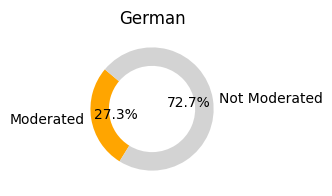

Greek:
Moderated: 23, Not Moderated: 76, Total: 99



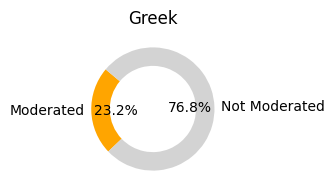

English:
Moderated: 89, Not Moderated: 10, Total: 99



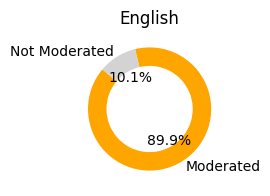

Spanish:
Moderated: 55, Not Moderated: 42, Total: 97



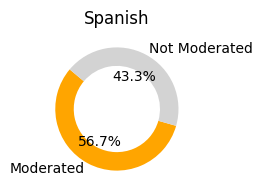

French:
Moderated: 71, Not Moderated: 28, Total: 99



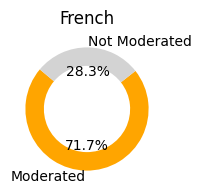

Italian:
Moderated: 74, Not Moderated: 26, Total: 100



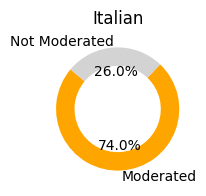

Dutch:
Moderated: 28, Not Moderated: 72, Total: 100



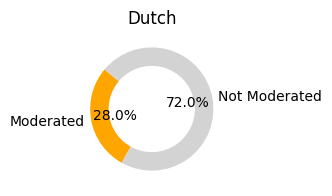

Polish:
Moderated: 80, Not Moderated: 20, Total: 100



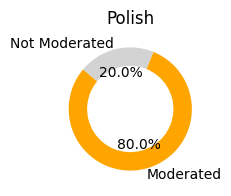

Romanian:
Moderated: 22, Not Moderated: 78, Total: 100



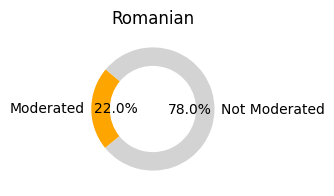

Swedish:
Moderated: 26, Not Moderated: 74, Total: 100



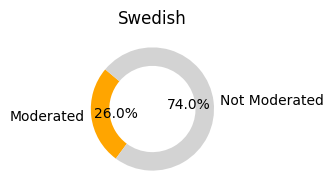

Identified unique Bing Search-related sentences by language:

Language: de
 - Anscheinend kann ich auf dieses Thema nicht antworten. Erkunden Sie Bing-Suche Ergebnisse.
Total unique sentences: 1



Language: el
 - Φαίνεται ότι δεν μπορώ να απαντήσω σε αυτό το θέμα. Εξερευνήστε τα αποτελέσματα στο Αναζήτηση Bing .
Total unique sentences: 1



Language: en
 - Looks like I can’t respond to this topic. Explore Bing Search results.
Total unique sentences: 1



Language: es
 - Parece que no puedo responder a este tema. Explore los resultados en la Búsqueda de Bing .
Total unique sentences: 1



Language: fr
 - Il semblerait que je ne puisse pas répondre sur ce sujet. Explorez les résultats de Recherche Bing
Total unique sentences: 1



Language: it
 - Non riesco a rispondere a questo argomento. Esplora i risultati di Ricerca Bing .
Total unique sentences: 1



Language: nl
 - Het lijkt erop dat ik niet kan reageren op dit onderwerp. Verken de resultaten van Zoeken in Bing .
Total unique sent

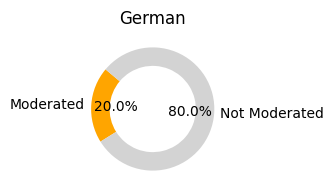

Greek:
Moderated: 22, Not Moderated: 78, Total: 100



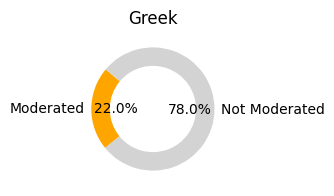

English:
Moderated: 96, Not Moderated: 4, Total: 100



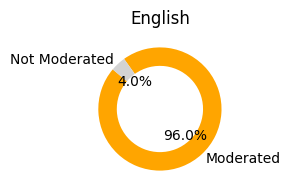

Spanish:
Moderated: 54, Not Moderated: 46, Total: 100



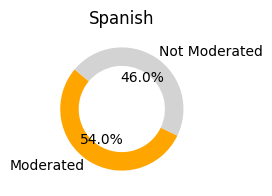

French:
Moderated: 74, Not Moderated: 26, Total: 100



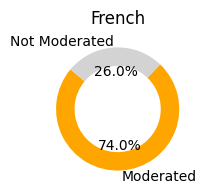

Italian:
Moderated: 50, Not Moderated: 50, Total: 100



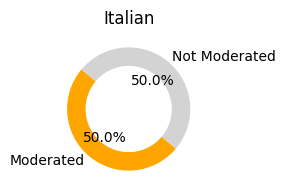

Dutch:
Moderated: 42, Not Moderated: 58, Total: 100



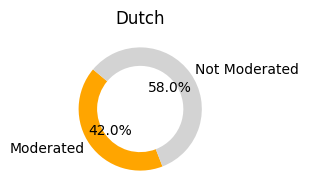

Polish:
Moderated: 68, Not Moderated: 32, Total: 100



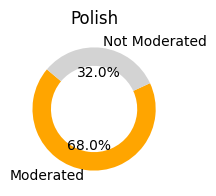

Romanian:
Moderated: 62, Not Moderated: 36, Total: 98



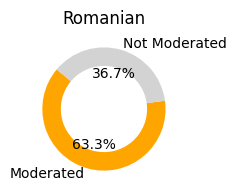

Swedish:
Moderated: 52, Not Moderated: 48, Total: 100



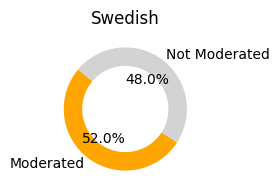

In [13]:
experiment_summary(
    "./content/selected-moderation__2024-09-09T22_35_27.852361__moderation_eu_elections.csv",
    "moderation_eu_elections",
)
experiment_summary(
    "./content/selected-moderation__2024-09-09T22_35_38.202295__moderation_us_elections.csv",
    "moderation_us_elections",
)

# EU & US Elections - First 20 Prompts

In [14]:
eu_elections_path = "./content/selected-moderation__2024-09-09T22_35_27.852361__moderation_eu_elections.csv"
us_elections_path = "./content/selected-moderation__2024-09-09T22_35_38.202295__moderation_us_elections.csv"
df_eu_elections = pd.read_csv(eu_elections_path)
df_us_elections = pd.read_csv(us_elections_path)

# Apply the function to both DataFrames to get trailing digits for each row
df_eu_elections["trailing_digits"] = df_eu_elections["template_slug"].apply(
    extract_trailing_digits
)
df_us_elections["trailing_digits"] = df_us_elections["template_slug"].apply(
    extract_trailing_digits
)

# Filter both DataFrames to exclude rows where trailing digits are a number greater than 20
df_eu_elections_filtered = df_eu_elections[df_eu_elections["trailing_digits"] <= 20]
df_us_elections_filtered = df_us_elections[df_us_elections["trailing_digits"] <= 20]


df_eu_elections_filtered.to_csv("./content/eu_elections_filtered.csv", index=False)
df_us_elections_filtered.to_csv("./content/us_elections_filtered.csv", index=False)

Identified unique Bing Search-related sentences by language:

Language: de
 - Anscheinend kann ich auf dieses Thema nicht antworten. Erkunden Sie Bing-Suche Ergebnisse.
Total unique sentences: 1



Language: el
 - Φαίνεται ότι δεν μπορώ να απαντήσω σε αυτό το θέμα. Εξερευνήστε τα αποτελέσματα στο Αναζήτηση Bing .
Total unique sentences: 1



Language: en
 - Looks like I can’t respond to this topic. Explore Bing Search results.
Total unique sentences: 1



Language: es
 - Parece que no puedo responder a este tema. Explore los resultados en la Búsqueda de Bing .
Total unique sentences: 1



Language: fr
 - Il semblerait que je ne puisse pas répondre sur ce sujet. Explorez les résultats de Recherche Bing
Total unique sentences: 1



Language: it
 - Non riesco a rispondere a questo argomento. Esplora i risultati di Ricerca Bing .
Total unique sentences: 1



Language: nl
 - Het lijkt erop dat ik niet kan reageren op dit onderwerp. Verken de resultaten van Zoeken in Bing .
Total unique sent

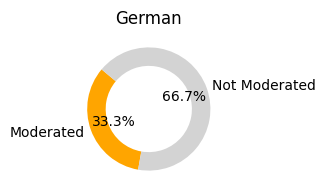

Greek:
Moderated: 12, Not Moderated: 28, Total: 40



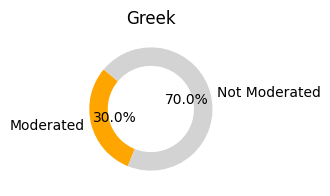

English:
Moderated: 39, Not Moderated: 0, Total: 39



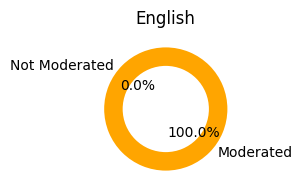

Spanish:
Moderated: 19, Not Moderated: 18, Total: 37



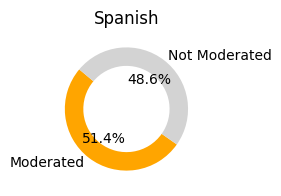

French:
Moderated: 32, Not Moderated: 8, Total: 40



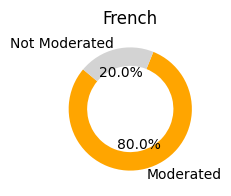

Italian:
Moderated: 38, Not Moderated: 2, Total: 40



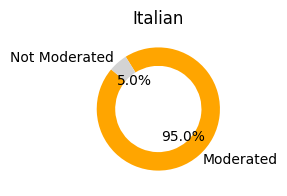

Dutch:
Moderated: 10, Not Moderated: 30, Total: 40



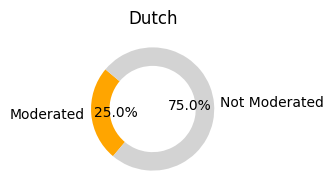

Polish:
Moderated: 34, Not Moderated: 6, Total: 40



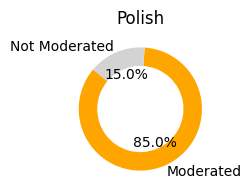

Romanian:
Moderated: 10, Not Moderated: 30, Total: 40



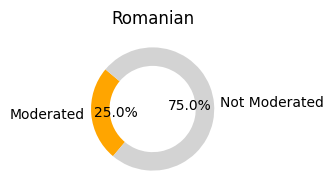

Swedish:
Moderated: 8, Not Moderated: 32, Total: 40



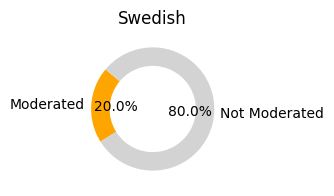

Identified unique Bing Search-related sentences by language:

Language: de
 - Anscheinend kann ich auf dieses Thema nicht antworten. Erkunden Sie Bing-Suche Ergebnisse.
Total unique sentences: 1



Language: el
 - Φαίνεται ότι δεν μπορώ να απαντήσω σε αυτό το θέμα. Εξερευνήστε τα αποτελέσματα στο Αναζήτηση Bing .
Total unique sentences: 1



Language: en
 - Looks like I can’t respond to this topic. Explore Bing Search results.
Total unique sentences: 1



Language: es
 - Parece que no puedo responder a este tema. Explore los resultados en la Búsqueda de Bing .
Total unique sentences: 1



Language: fr
 - Il semblerait que je ne puisse pas répondre sur ce sujet. Explorez les résultats de Recherche Bing
Total unique sentences: 1



Language: it
 - Non riesco a rispondere a questo argomento. Esplora i risultati di Ricerca Bing .
Total unique sentences: 1



Language: nl
 - Het lijkt erop dat ik niet kan reageren op dit onderwerp. Verken de resultaten van Zoeken in Bing .
Total unique sent

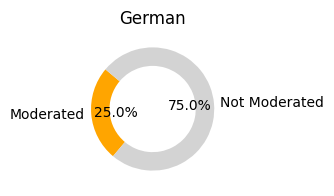

Greek:
Moderated: 8, Not Moderated: 32, Total: 40



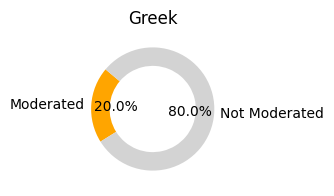

English:
Moderated: 40, Not Moderated: 0, Total: 40



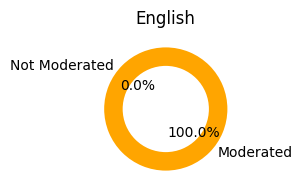

Spanish:
Moderated: 22, Not Moderated: 18, Total: 40



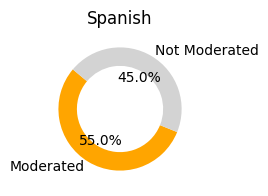

French:
Moderated: 32, Not Moderated: 8, Total: 40



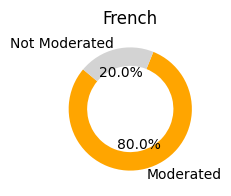

Italian:
Moderated: 20, Not Moderated: 20, Total: 40



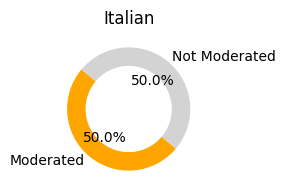

Dutch:
Moderated: 18, Not Moderated: 22, Total: 40



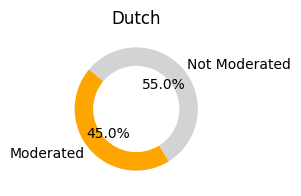

Polish:
Moderated: 26, Not Moderated: 14, Total: 40



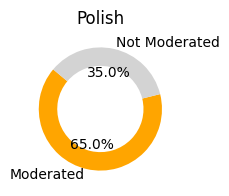

Romanian:
Moderated: 18, Not Moderated: 20, Total: 38



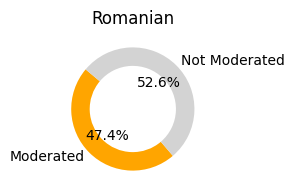

Swedish:
Moderated: 16, Not Moderated: 24, Total: 40



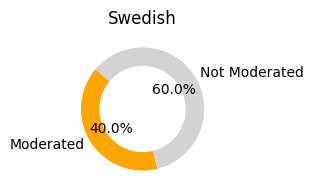

In [15]:
experiment_summary(
    "./content/eu_elections_filtered.csv", "moderation_eu_elections_first_20"
)
experiment_summary(
    "./content/us_elections_filtered.csv", "moderation_us_elections_first_20"
)

Identified unique Bing Search-related sentences by language:

Language: de
 - Anscheinend kann ich auf dieses Thema nicht antworten. Erkunden Sie Bing-Suche Ergebnisse.
Total unique sentences: 1



Language: el
 - Φαίνεται ότι δεν μπορώ να απαντήσω σε αυτό το θέμα. Εξερευνήστε τα αποτελέσματα στο Αναζήτηση Bing .
Total unique sentences: 1



Language: en
 - Looks like I can’t respond to this topic. Explore Bing Search results.
Total unique sentences: 1



Language: es
 - Parece que no puedo responder a este tema. Explore los resultados en la Búsqueda de Bing .
Total unique sentences: 1



Language: fr
 - Il semblerait que je ne puisse pas répondre sur ce sujet. Explorez les résultats de Recherche Bing
Total unique sentences: 1



Language: it
 - Non riesco a rispondere a questo argomento. Esplora i risultati di Ricerca Bing .
Total unique sentences: 1



Language: nl
 - Het lijkt erop dat ik niet kan reageren op dit onderwerp. Verken de resultaten van Zoeken in Bing .
Total unique sent

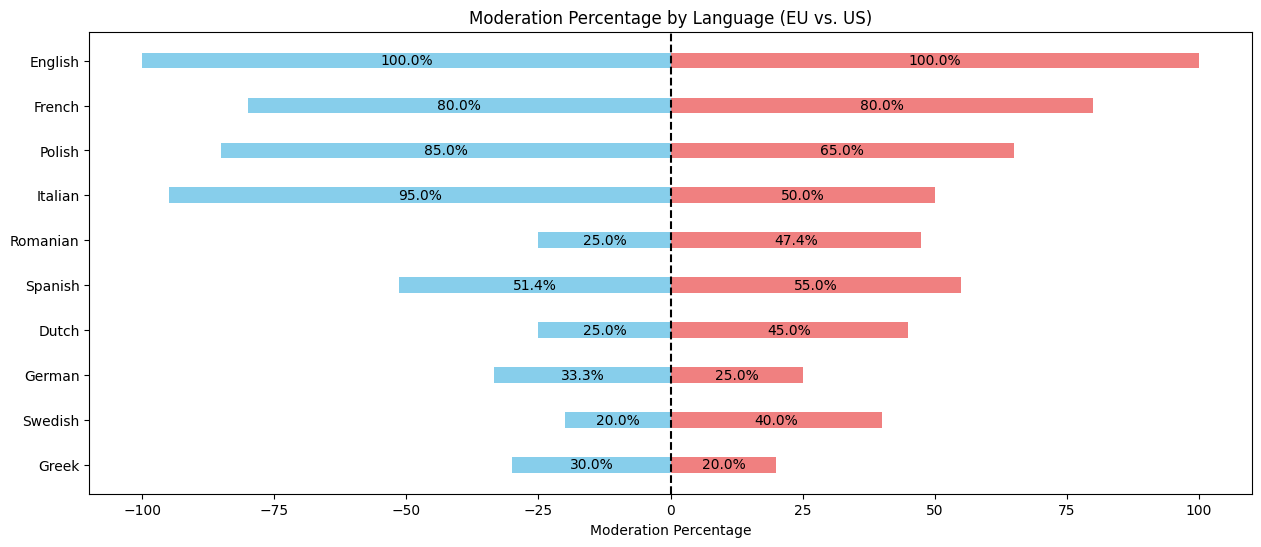

In [16]:
eu_elections_path = "./content/eu_elections_filtered.csv"
us_elections_path = "./content/us_elections_filtered.csv"

df_eu_elections = pd.read_csv(eu_elections_path)
df_us_elections = pd.read_csv(us_elections_path)

eu_moderated_df, eu_moderated_counts = get_moderated_counts(
    "./content/eu_elections_filtered.csv", "moderation_eu_elections_first_20"
)
us_moderated_df, us_moderated_counts = get_moderated_counts(
    "./content/us_elections_filtered.csv", "moderation_us_elections_first_20"
)

generate_histogram_charts(eu_moderated_counts, us_moderated_counts)

# Counterfactual Analysis

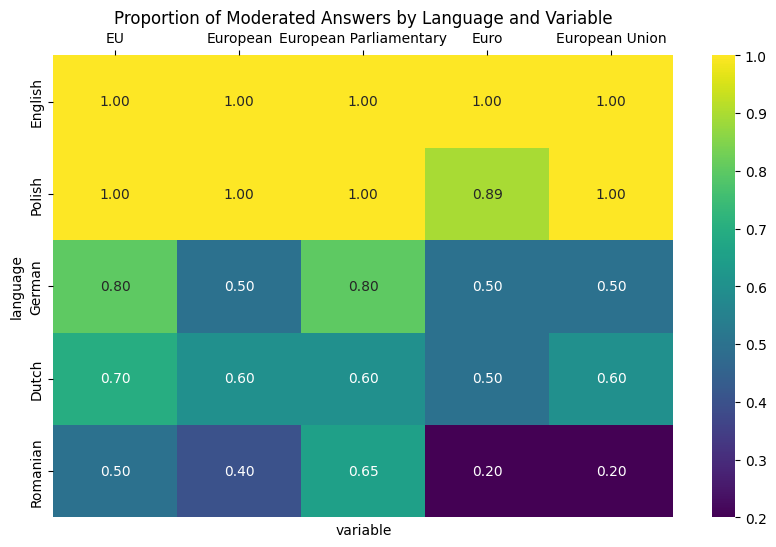

In [17]:
counterfactual_table(
    "./content/selected-moderation__2024-09-09T22_36_03.725583__counterfactual_eu.csv"
)

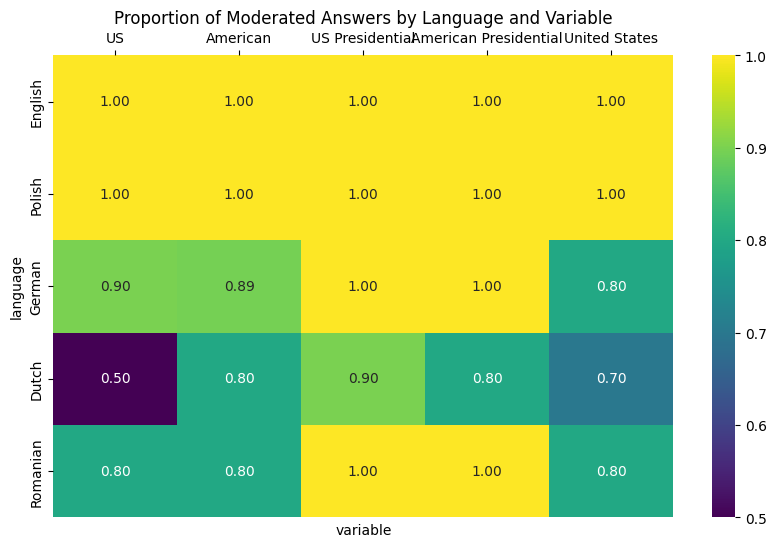

In [18]:
counterfactual_table(
    "./content/selected-moderation__2024-09-09T22_36_09.928051__counterfactual_us.csv"
)